In [ ]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm

#### Numpy & Python Version 확인

In [ ]:
import numpy as np
import platform

# NumPy 버전 확인
numpy_version = np.__version__

# Python 버전 확인
python_version = platform.python_version()

print(f"NumPy 버전: {numpy_version}")
print(f"Python 버전: {python_version}")

NumPy 버전: 1.24.3
Python 버전: 3.11.9


#### CUDA 사용 및 EarlyStopping 설정

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cuda:0


#### 모델 저장

In [ ]:
def saveModel():
    torch.save(model.state_dict(), 'F:/응용통계학과/4학년 1학기/학부연구생/LSTM/논문 구현/model_lstmautoencoder.pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [ ]:
# 하이퍼파라미터 설정
length = 12            # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
trainrun = 250       # 생성할 학습 데이터 시퀀스의 수
validrun = 125         # 생성할 검증 데이터 시퀀스의 수

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수 (phi값을 0.25, 0.5, 0.75, 0.95별로 생성)
phi1 = np.array([0.25, 0.5, 0.75, 0.95])

# 변화율 크기
psi1 = 0

# 공정의 수준 변화율 (delta)
de1 = 0

# 공정의 분산 변화율 (gamma)
ga = 1

#### 시계열 데이터 생성

In [ ]:
np.random.seed(1)

# AR(1) 시계열 데이터 생성 함수
def ar(ar1, delta, gamma, psi, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                           # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이)
    sigma = math.sqrt(1 / (1 - pow(ar1, 2)))                    # AR(1)모델의 표준 편차

    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)
        x = np.zeros(length)

        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)

        # psi 시점 이전의 데이터 생성
        for i in range(1, psi):                                 # psi 시점 이전까지는 관리상태 데이터
            x[i] = ar1 * x[i - 1] + e[i]                        # 각 시점에서의 값은 이전 시점의 값에 자기상관 계수 ar1을 곱한 것과 현재 시점의 노이즈를 더한 값으로 설정

            # psi 시점 이후의 데이터 생성 및 변동성 적용
            if i >= psi:                                        # psi 시점 이후에는 각 에러 항에 gamma 값을 곱하여 에러 항의 변동성을 조절
                e[i] = gamma * e[i]
                x[i] = ar1 * x[i - 1] + e[i] + delta * sigma    # delta(변동성 크기 조절하는 매개변수)를 통한 추가 변동성 적용

        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)
        y[j] = x

    return y


# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i, phi in enumerate(phi1):
        y[i]= ar(phi, de1, ga, psi1, length, run)

    return y.reshape(run * len(phi1), length)                   # 생성된 데이터를 적절한 형태로 재배열


In [ ]:
# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi1),length)

# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi1),length)

# PyTorch 텐서로 변환 및 장치 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.FloatTensor(train_x).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)

# DataLoader 설정
trainloader = DataLoader(train_x, shuffle=True)                  # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
validloader = DataLoader(valid_x, shuffle=False)                # 학습 및 검증에서는 데이터 순서 유지

In [ ]:
for data in trainloader:
    print(data.shape)
    break

torch.Size([1, 12])


In [ ]:
len(trainloader)

1000

In [ ]:
len(validloader)

500

In [ ]:
train_x.shape[1]

12

#### LSTM Autoencoder 구조

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# LSTM Encoder 클래스 정의
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(LSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.hidden_to_latent(hidden[-1])

# LSTM Decoder 클래스 정의
class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_length):
        super(LSTMDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.outputs_to_data = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = self.latent_to_hidden(z).unsqueeze(0)
        repeated_z = z.repeat(self.seq_length, 1, 1).transpose(0, 1)
        lstm_out, _ = self.lstm(repeated_z)
        return self.outputs_to_data(lstm_out)

# 전체 LSTM 오토인코더 모델
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim=128, latent_dim=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_length)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# 모델 인스턴스 생성 및 설정
model = LSTMAutoencoder(input_dim=length, seq_length=length, hidden_dim=128, latent_dim=1)
model = model.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

c:\Users\Pro\anaconda3\envs\myenv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([1, 12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 0.0934, Validation Loss: 0.0916
Validation loss decreased (inf --> 0.091558).  Saving model ...
Epoch 2, Train Loss: 0.0921, Validation Loss: 0.0906
Validation loss decreased (0.091558 --> 0.090612).  Saving model ...
Epoch 3, Train Loss: 0.0913, Validation Loss: 0.0901
Validation loss decreased (0.090612 --> 0.090099).  Saving model ...
Epoch 4, Train Loss: 0.0910, Validation Loss: 0.0898
Validation loss decreased (0.090099 --> 0.089843).  Saving model ...
Epoch 5, Train Loss: 0.0908, Validation Loss: 0.0897
Validation loss decreased (0.089843 --> 0.089722).  Saving model ...
Epoch 6, Train Loss: 0.0907, Validation Loss: 0.0897
Validation loss decreased (0.089722 --> 0.089658).  Saving model ...
Epoch 7, Train Loss: 0.0906, Validation Loss: 0.0896
Validation loss decreased (0.089658 --> 0.089609).  Saving model ...
Epoch 8, Train Loss: 0.0906, Validation Loss: 0.0896
Validation loss decreased (0.089609 --> 0.089561).  Saving model ...
Epoch 9, Train Loss: 0.0905, 

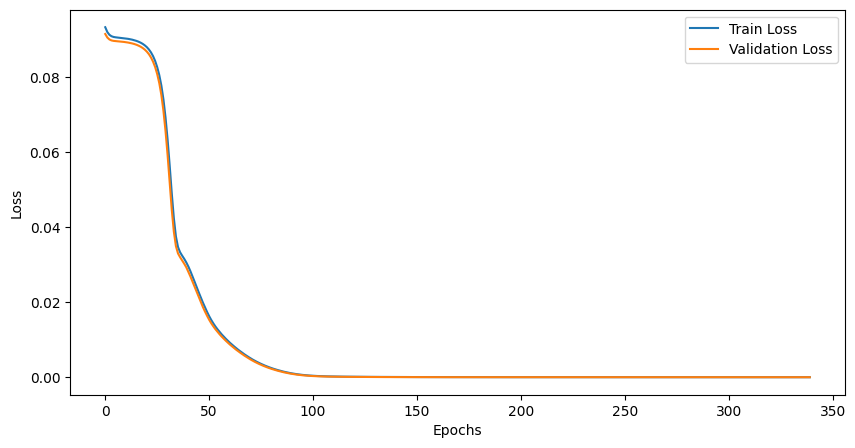

In [ ]:
def training(epochs):
    loss_ = []
    valoss_ = []

    # epoch 별 훈련 및 검증 루프 (trainloader를 반복하여 모델 훈련시키고, validloader를 사용해 모델의 성능 검증)
    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0

        # 훈련 과정
        for data in trainloader:
            model.train()
            inputs = data
            inputs = inputs.to(device)
            optimizer.zero_grad()                                                   # Optimizer Gradient를 0으로 초기화. 이는 각 미니배치마다 Gradient가 누적되는 것을 방지
            predicted_outputs = model(inputs)                                       # 모델을 사용하여 입력 데이터에 대한 예측값을 계산
            train_loss = criterion(predicted_outputs, inputs)                       # 계산된 예측값과 실제 값 간의 손실을 계산
            train_loss.backward()                                                   # 손실에 대한 역전파를 수행하여 Gradient를 계산
            optimizer.step()
            running_train_loss += train_loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(trainloader)
        loss_.append(avg_train_loss)

        # 검증 과정
        with torch.no_grad():
            model.eval()
            for data in validloader:
                inputs = data
                inputs = inputs.to(device)
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, inputs)
                running_vall_loss += val_loss.item()

            avg_val_loss = running_vall_loss / len(validloader)
            valoss_.append(avg_val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Save model
    saveModel()
    return loss_, valoss_

loss_, valoss_ = training(epochs=400)

# Loss visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_, label='Train Loss')
plt.plot(valoss_, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### ARL0 구하기

In [ ]:
np.random.seed(1)

l = 12

# 관리상태 / 이상상태 데이터 생성 함수
def argen(ar, psi, delta,gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt(1 / (1 - pow(ar, 2)))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(1, psi):
        x[i] = ar * x[i-1] + e[i]
        z[i] = x[i]
    for i in range(psi,len(x)):
        x[i] = ar * x[i - 1] + gamma*e[i]
        z[i] = x[i]
    for i in range(psi,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [ ]:
def arl(ar,delta,gamma, run, length,cl) :
    rl = np.array([], dtype=np.float64)

    for i in tqdm(range(run)) :
        y = argen(ar=ar, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                output = model(input)

                mse_loss = nn.MSELoss()
                loss = mse_loss(output[0], input[0]) # output shape 확인

                if (loss > cl).any() :
                    a = np.array([j + 1])
                    break
                elif j == len(x) - 1:
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl

#### ARL1 구하기

In [ ]:
def arl1(ar,run,length,cl):
    a5 = arl(ar, 0.5, 1, run, length, cl)
    a1 = arl(ar, 1, 1, run, length, cl)
    a2 = arl(ar, 2, 1, run, length, cl)
    a3 = arl(ar, 3, 1, run, length, cl)
    b5 = arl(ar, 0.5, 1.5,run, length, cl)
    b1 = arl(ar, 1, 1.5, run, length, cl)
    b2 = arl(ar, 2, 1.5, run, length, cl)
    b3 = arl(ar, 3, 1, run, length, cl)
    c1 = arl(ar, 0, 1.5, run, length, cl)
    c2 = arl(ar, 0, 2, run, length, cl)
    c3 = arl(ar, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

#### phi = 0.25 일 때

##### ARL0 (threshold 임의추정)

In [ ]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 2.18)

100%|██████████| 10000/10000 [25:50<00:00,  6.45it/s]


278.8572

In [ ]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 2.3)

100%|██████████| 10000/10000 [33:54<00:00,  4.92it/s]


370.6138

##### ARL1

In [ ]:
arl1(ar = 0.25, run = 10000, length = 1000, cl = 2.3)

100%|██████████| 10000/10000 [00:29<00:00, 333.70it/s]

0.5: 103.3649, 1:21.8216,2:4.9169,3:2.4772
0.5:14.2495,1:9.4149,2:4.4184,3:2.4789
1.5:16.9843,2:7.1939,3:3.586
